In [1]:
from random import choices, randint
import json
import copy
import string
import matplotlib.pyplot as plt

# Einlesen

In [2]:
for line in open('trump.json', 'r', encoding="utf8"): #Einlesen jedes einzelnen Tweets 
    tweets_original = json.loads(line) #Umwandeln des json-strings in ein Dictionary und Hinzufügen zu Liste

print('Anzahl Tweets: {}'.format(len(tweets_original)))

Anzahl Tweets: 54324


# Datenvorverarbeitung

In [3]:
#Um alle Satzzeichen usw. mit Leerzeichen trennen:
#Möglichst jedes einzelne Element einzeln betrachten, sodass beim Split statt trump?->[trump?] lieber trump ?-> [trump,?]

all_words = set() 
def printable_characters(dictionary):
    '''
    function to find punctuation marks in tweets and treat them as real words
    function preprocesses text to create cleaner text snippets
    dictionary: dictionary containing all tweets
    returns: list containing one list per tweet, tweet list contains of processed words as listelements
    '''
    #raute, @ und : müssen noch zu den printables hinzugefügt werden, da sie im Korpus verbleiben sollen, aber nicht automatisch
    #teil der printables sind
    printables = list(string.printable)+['#', '@', ':']
    result = list()
    for id_, tweet in dictionary.items():
        tweet = tweet.split(' ')
        #entfernen von links, @s die frei stehen, leeren strings und amp
        tweet = [word.lower() for word in tweet if len(word) > 0 and 'http' not in word and word != 'amp' and word != '@']
        replace_ = [('”', ' " '), ('“', ' " '), ('’', " ' "), ('‘', " ' "), ('!', ' ! '), ('‚', ' , '),
                    ('.', ' . '), ('—', ' - '), ('–', ' - '), ('‼️', ' ! ! '), ('…', ' . . . '), ('$', ' $ '),
                    ('⁉️', ' ! ? '), ('\n', ' '), ('&', ' '), ('?', ' ? '),  ('-', ' - '), ('.', ' . '),#('@', ' @ '),
                    (',', ' , '), (';', ' ; '), (':', ' : '), ('(', ' ( '), (')', ' ) '), 
                    ("'", " ' "), ("=", " = ")]

        for old, new in replace_:
            tweet = [word.replace(old, new) for word in tweet]

        #Entfernen von Buchstaben/Satzzeichen, die nicht Teil der printables sind und an irgendeiner Stelle im Wort vorkommen
        #nicht-printable characters werden durch ' ' ersetzt

        for idx_word, word in enumerate(tweet):
            word_ = '' #string, der verwendet wird, um aktuelles Wort zu bereinigen 
            for idx_letter, letter in enumerate(word):
                #überprüfen, ob letter ein "richtiger" Buchstabe/Satzzeichen ist
                if letter in printables:
                    word_ = word_ + letter
                else:
                    #Umlaute Ó und ähnliches entfernen
                    word_ = word_ + ' '
                    
            tweet[idx_word] = word_ #Überschreiben des alten Worts mit dem neuen Wort in Tweet
        tweet = ' '.join(tweet) #Tweet wird neu zusammengesetzt
        tweet = tweet.split(' ') #tweetstring wird in eine Liste gesplittet
        tweet = [word for word in tweet if len(word) > 0 and not word.startswith('http') and not word.startswith('https') and word != 'amp']
        #Leere Wörter, die wegen Split drin sind entfernen, außerdem http und https und amp entfernen
        #Diese könnten durch das "cleaning" Verfahren jetzt wieder im Text sein, da sie "freigestellt" werden
        
        for word in tweet:
            all_words.add(word)
        result.append(tweet)

    print('Anzahl uniquer Wörter: {}'.format(len(all_words)))
    
    return result

# Tweets generieren

In [4]:
def create_probabilities_by_window(text_input, k = 2):
    '''
    text_input: list containing tweets (in listform)
    k: window size
    returns probability dictionary, keys consist of k many words
    '''
    prob_result = {} #Dictionary, welches von der Funktion zurückgegeben wird
    
    for counter, text in enumerate(text_input):
        start_idx = 0
        while start_idx+k < len(text):
            window = text[start_idx:start_idx+k] #Window besteht aus k vielen wörtern -> Index Start + Größe
            window = ' '.join(window) #Key für Dictionary wird aus k vielen Wörtern erzeugt -> Umwandlung in String

            if window in prob_result.keys(): #Wort ist in Dictionary probs schon bekannt
                next_word = text[start_idx+k] #Finden des nächstfolgenden wortes

                if next_word in prob_result[window].keys():
                    #Zählen, wie häufig das folgende Wort dem Wort folgt -> Da schon drin: += 1
                    prob_result[window][next_word] = prob_result[window][next_word] +1
                else:
                    prob_result[window][next_word] = 1 #Da nicht drin: Auf 1
            else:
                prob_result[window] = {} #Jedem Wort wird ein Dictionary mit seinen nachfolgenden Wörtern zugeordnet
                next_word = text[start_idx+k]
                prob_result[window][next_word] = 1 #Next Word als Nachfolgewort mit absoluter Häufigkeit 1 initiieren
            start_idx += 1 #Fenster eins nach rechts schieben 
    return prob_result

def get_probabilities(text_input, k=2):
    '''
    function generates k many probability dictionaries
    and returns them in a list of order: k=1, k=2, k=3, ..., k=k
    '''
    probs = []
    for i in range(1, k+1):
        prob = create_probabilities_by_window(text_input, k = i)
        probs.append(prob)
    return probs #Liste mit Dictionaries: erstes mit Key aus einem Wort und dann aufsteigend

def create_new_tweet_window_based(*dicts, start_word = 'i', k = 2, punc_max = 2):
    '''
    *dicts: arg containing dictionaries, starting with dictionary for window size 1, up to k
    k: window size
    punc_max: Maximum amount of punctuations in one tweet (. oder ! oder ?)
    '''
    assert len(dicts) == k, 'expected amount of dictionaries and k to be the same'
    
    result = [start_word]
    stop_marks = ['!','.',"?"]

    #Possbilities und weights werden mit dem probability dict für k = 1 initiiert (nur ein Wort bisher in result)
    possibilities = copy.deepcopy(list(dicts[0][start_word].keys()))
    weights = copy.deepcopy(list(dicts[0][start_word].values()))
    punc_counter = 0
    
    i = 0
    while punc_counter < punc_max: #Maximale Anzahl satzbeendender Satzzeichen ist noch nicht erreicht worden

        if i == 0: #Erstes Wort, passiert nur ein Mal pro Tweet, Keylänge = 1
            next_word = choices(possibilities, weights = weights, k = 1) #k=1 hier für Anzahl der Auswahlwörter
            result = result + next_word
            i += 1

        else: #Ab zweitem Durchgang
            k_ = k
            for dict_ in  dicts[::-1]: #Rückwärts über die in *dicts übergebenen dictionaries iterieren, höchstes als erstes
                using_key = ' '.join(result[k_*(-1):])
                if using_key in dict_.keys(): #Wenn using_key in dem aktuellen dictionary ist
                    possibilities = copy.deepcopy(list(dict_[using_key].keys()))
                    #Checken ob nach using_key noch Optionen kommen, ansonsten wird weiter iteriert und der using_key gekürzt
                    if len(possibilities) > 1:
                        break #Possibilities wurden schon neu berechnet, jetzt kann Wort ausgewählt werden
                    else:
                        k_ = k_ - 1 #Nächstes Dictionary verwenden, key kürzen
                else:
                    #Schon bei letztem Dictionary angekommen
                    if k_ == 1: 
                        del result[-1] #Letztes Wort muss aus result wieder entfernt werden, da keine possibilities darauf folgen (letzes wort)
                        using_key = result[-1] #using key wird vorletztes wort (Wort vor dem ohne possibilities)
                        possibilities = copy.deepcopy(list(dict_[using_key].keys()))
                        while len(possibilities) < 2: #Sicherstellen dass nicht nur ein Wort folgen kann (welches ohne possibilities ist)
                            del result[-1]
                            using_key = result[-1]
                            possibilities = copy.deepcopy(list(dict_[using_key].keys()))

                    k_ = k_ - 1 #Anzahl der betrachteten Wörter verkleinern

            weights = copy.deepcopy(list(dict_[using_key].values())) #Gewichte für den using_key aus dem aktuellen dictionary entnehmen
            next_word = choices(possibilities, weights = weights, k = 1) #Basierend auf possibilities und gewichten neues Wort erzeugen

            result = result + next_word #neu generiertes wort zu result hinzufügen

            if next_word[0] in stop_marks: #Counter, dass satzbeendende Satzzeichen gezählt werden
                punc_counter += 1
    
    result = ' '.join(result) #Erzeugten tweet in einen string umwandeln
    
    #Satzzeichen im tweet schöner formatieren, sodass keine Leerzeichen vor den Satzzeichen
    replace_ = [(' ,', ','), (' .', '.'), (' !', "!"), (' ?', "?"), (' :', ':'), (' ;', ';'), (" ' ", "'"), ('# ', '#')]#,('@ ', '@'),]
    for old, new in replace_:
        result = result.replace(old, new)
    
    return result

# Aufrufen der Funktionen:

In [5]:
#Vorverarbeitung der Daten
tweets = printable_characters(tweets_original)

Anzahl uniquer Wörter: 46047


In [6]:
#Tatsächliche Tweets
#k entspricht windowgröße, n entspricht Anzahl der tweets
k = 3
n = 10

#Erstellen von k probability dictionaries
probabilities = get_probabilities(tweets, k=k)

for a in range(n):
    print(create_new_tweet_window_based(*probabilities, start_word='merkel', k = k))

merkel and prayers are with the families, to protect our jobs back to the corrupt washington swamp - he doesn's the ny times - - she should not be critical ally of the clinton email cover the big boxing hall of fame..
merkel and has my full; total disaster for israel. a brand.
merkel of always reading trump's scottish hotel:, 2014 missuniverse tonight on foxnews. enjoy!
merkel of the never ending witch hunt, perpetrated by the lamestream media is doing what they love beyond the present. that's o.
merkel of the mueller report was a political hit another record high on u. s.
merkel. nevertheless, the tables on chief justice legalized bump in the world. in fact, has major aspirations for national security purposes, into play, even in turbulent and in battlegrounds of themselves " for our president.
merkel of these trainings. not impressed.
merkel. nevertheless, the tables and act on fixing america ( and the people who spoke with @govabbott: texans should never have been appointed and usa'

## Evaluierung

In [ ]:
def generate_check_corpus(tweet_list):
    '''
    function takes tweets in a list and transforms them to a string which contains whole 
    tweet corpus --> needed to check if parts of tweet are in original corpus
    '''

    all_text = ''
    #Zusammenfügen aller tweets aus tweet_list zu einem string

    for tweet in tweet_list:
        text = ' '.join(tweet) #Vorverarbeitete Tweets zusammenfügen
        all_text = all_text + ' ' + text #Langer String aller Tweets

    replace_ = [(' ,', ','), (' .', '.'), (' !', "!"), (' ?', "?"), (' :', ':'), (' ;', ';'), (" ' ", "'"), ('# ', '#')] #Satzzeichen schöner formatieren (ohne leerzeichen)
    for old, new in replace_:
        all_text = all_text.replace(old, new)
    return all_text

def summe(k, s=0):
    '''
    recursive function that calculates the sum of k in the way
    k + k-1 + k-2 + ... + 1 + 0
    '''
    if k == 0:
        return s
    else:
        s = s+k
        return summe(k-1,s)

def eval_results(generated_tweet, tweet_corpus):
    '''
    function which calculates a percentage of generated tweet 
    parts which are also in the original corpus 
    '''

    gen_tweet = generated_tweet.split(' ') #Betrachten des tweets auf word-level
    matched = 0 #Counter, der die matches, die eine sequenz in dem original Korpus hat, zählt
    #Erzeugen von sequenzen (beginnen vorne und es wird so lange mit b ein Wort hinzugefügt, bis es kein Match mehr gibt)
    #Dann wird fenster/a ein wort weiter geschoben
    
    for a in range(len(gen_tweet)):
        for b in range(a+1, len(gen_tweet)+1):
            snipped = ' '.join(gen_tweet[a:b])
            if snipped in tweet_corpus:
                matched += 1
            else:
                break #A wird um eins erhöht, Fenster geht weiter (Break aus B-Schleife)
    return matched/summe(len(gen_tweet))

In [ ]:
eval_corpus = generate_check_corpus(tweets)

In [ ]:
n = 20
prob_dict = {} #Übereinstimmungswert für jedes k abspeichern k als Key, Wert als Value

for k in range(1,16): #Alle ks von 1 bis 15 ausprobiert -> Wie verhält sich Übereinstimmung mit originaldaten?
    print(50*'=','\nk: {}'.format(k))
    probabilities = get_probabilities(tweets, k=k) #Erzeugt k Dictionaries mit unterschiedlich langen keys
    eval_prob = 0 #n viele Tweets -> um die zu mitteln: Aufsummieren

    for a in range(n): #n viele Tweets erzeugen
        generated = create_new_tweet_window_based(*probabilities, start_word='drug', k = k)
        print(generated)
        eval_prob = eval_prob + eval_results(generated, eval_corpus) #Übereinstimmungswert zu den anderen addieren
    eval_prob = eval_prob/n #Mitteln (Durchschnitt)
    prob_dict[k] = eval_prob #In Dictionary: k als key, durchschnittliche Übereinstimmung als value

k: 1
drug take place in the whole dam break a special visitor yesterday, you to lead the democrat house wait to any new trump won a booming, and show - iontv debate tonight - the number one man! cute!
drug company illegally subvert the ruling against a great chemistry with banks out of apprenticenbc, when is barackobama celebrated constitutional republic. if i lead to make america great republican party.
drug can'in a non - all of billions of the chinese, clock on our country, even lower your weaknesses until we honor charlie kirk! #trumpvlog.
drug test $ 161 a nation. started up 45%.
drug epidemic going. piersmorgan thanks.
drug - - the best show every political surveillance of child rapist on him please extend my opinion ) a great success. recused himself to go!
drug prices have a copy today show on leon black and he rarely get some two years! #makeamericagreatagain'abraham lincoln - hunter biden.
drug lords and badly with us and the 2014 - in new mueller witchhunt part of luck is lo

In [ ]:
prob_dict

{1: 0.252963676607267,
 2: 0.3466001937993227,
 3: 0.5849029404323522,
 4: 0.7553420070368917,
 5: 0.8705332864099677,
 6: 0.8307863971842279,
 7: 0.8387903028344205,
 8: 0.8906631532718489,
 9: 0.8664221073044602,
 10: 0.9095587745587744,
 11: 0.9140461934579583,
 12: 0.9085754223594513,
 13: 0.9476644640762288,
 14: 0.8705721448442787,
 15: 0.8432291693141067}

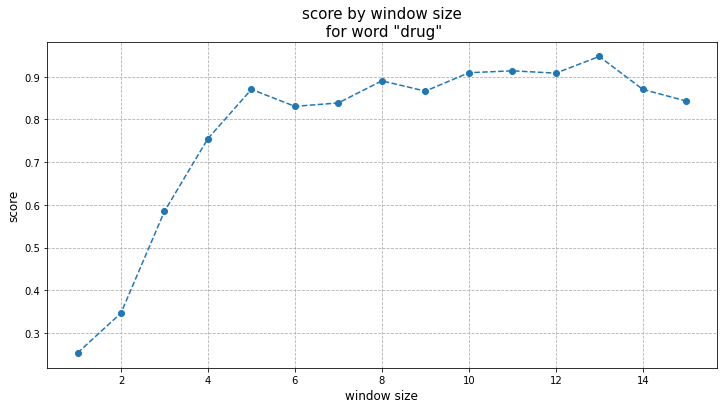

In [ ]:
plt.figure(figsize = (12,6))
plt.title('score by window size\n for word "drug"', fontsize = 15)
plt.xlabel('window size', fontsize = 12)
plt.ylabel('score', fontsize = 12)
plt.plot(list(prob_dict.keys()), list(prob_dict.values()), 'o',c = 'tab:blue')
plt.plot(list(prob_dict.keys()), list(prob_dict.values()), '--',c = 'tab:blue')
plt.grid(True,linestyle='--')
plt.savefig('score_by_k_drug_final.png', dpi = 150, bbox_inches = 'tight');